# Detectron2 on Windows/Linux

To begin with, we've used the idea from [this video](https://www.youtube.com/watch?v=8eLHZ0R5nHQ) and if in any situation you have to use windows, follow [these steps](https://stackoverflow.com/questions/60631933/install-detectron2-on-windows-10/) to install detectron.

The Images are downloaded from here : https://www.pexels.com/

### Task

Here, we are trying to train a detectron which could detect drones from a still image or from a video stream. We will keep on improving this but this is a very simple startup example.

### Initial Setup

In [ ]:
!pip install cython pyyaml
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

**If you are using linux, run the below cell.**

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 ../detectron2_repo
!pip install -q -e ../detectron2_repo

### Libraries and data Import

In [2]:

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import os
import cv2
from matplotlib import pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances


This is where we're registering the json annotations and the image folder to some experiment

In [3]:
register_coco_instances('experiment_drone_1', {}, 'D:/Dataset/drone_images/annotations/annotations.json', 'D:/Dataset/drone_images/drone_images/')

In [7]:
sample_metadata = MetadataCatalog.get('experiment_drone_1')
dataset_dicts = DatasetCatalog.get('experiment_drone_1')

WARNING [03/19 18:48:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/19 18:48:41 d2.data.datasets.coco]: Loaded 20 images in COCO format from D:/Dataset/drone_images/annotations/annotations.json


### Initializes Training

Here, we'll choose the model `faster_rcnn_R_50_FPN_3x.yaml` to train and fit our dataset on it.

In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("experiment_drone_1",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")# initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 600   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 3 classes (Person, Helmet, Car)

Start the training

In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[03/19 12:43:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:13, 12.0MB/s]                               
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box

[03/19 12:44:19 d2.engine.train_loop]: Starting training from iteration 0
[03/19 12:44:40 d2.utils.events]:  eta: 0:04:57  iter: 19  total_loss: 1.051  loss_cls: 0.4157  loss_box_reg: 0.4668  loss_rpn_cls: 0.002457  loss_rpn_loc: 0.007596  time: 0.5918  data_time: 0.2372  lr: 0.0006527  max_mem: 2517M
[03/19 12:44:53 d2.utils.events]:  eta: 0:05:00  iter: 39  total_loss: 0.5814  loss_cls: 0.13  loss_box_reg: 0.4151  loss_rpn_cls: 0.002173  loss_rpn_loc: 0.005751  time: 0.6031  data_time: 0.0797  lr: 0.0013187  max_mem: 2731M
[03/19 12:45:05 d2.utils.events]:  eta: 0:04:49  iter: 59  total_loss: 0.4774  loss_cls: 0.08088  loss_box_reg: 0.379  loss_rpn_cls: 0.0003785  loss_rpn_loc: 0.006366  time: 0.6024  data_time: 0.0929  lr: 0.0019847  max_mem: 2731M
[03/19 12:45:17 d2.utils.events]:  eta: 0:04:46  iter: 79  total_loss: 0.3525  loss_cls: 0.06544  loss_box_reg: 0.2837  loss_rpn_cls: 0.000149  loss_rpn_loc: 0.004821  time: 0.6074  data_time: 0.1022  lr: 0.0026507  max_mem: 2731M
[03/19 

### Initializing Predictions

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95   # the testing threshold for this model
# cfg.DATASETS.TEST = ("experiment_drone_1",)
predictor = DefaultPredictor(cfg)

Locate drone in the new image

In [14]:
def locate_drone_and_show(img_path):

    im = cv2.imread(img_path)
    outputs = predictor(im)
    v = Visualizer(im,
                    metadata=sample_metadata, 
                    scale=0.8, 
                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_image = v.get_image()

    plt.figure(figsize=(20,10))
    plt.imshow(result_image[..., ::-1])


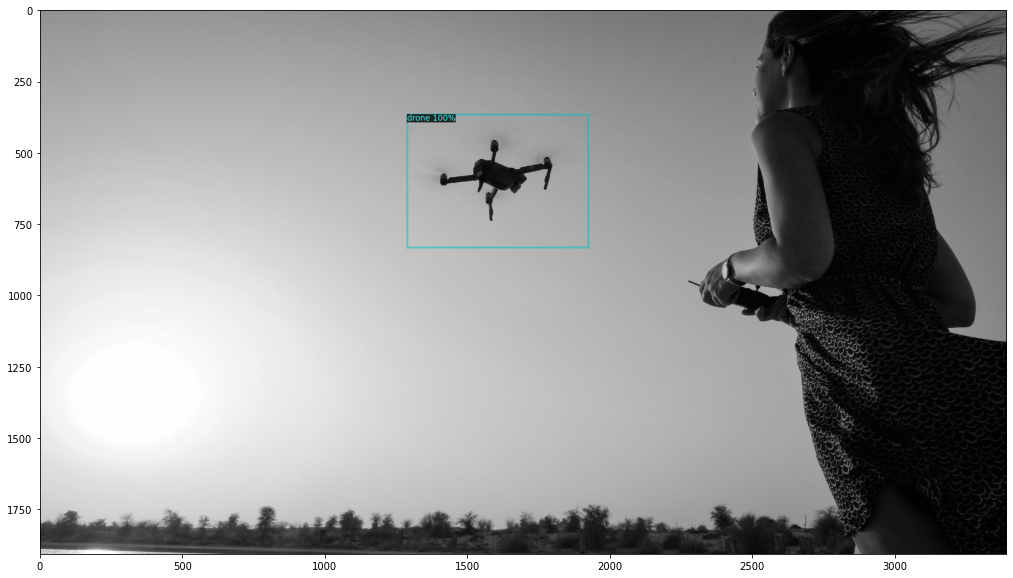

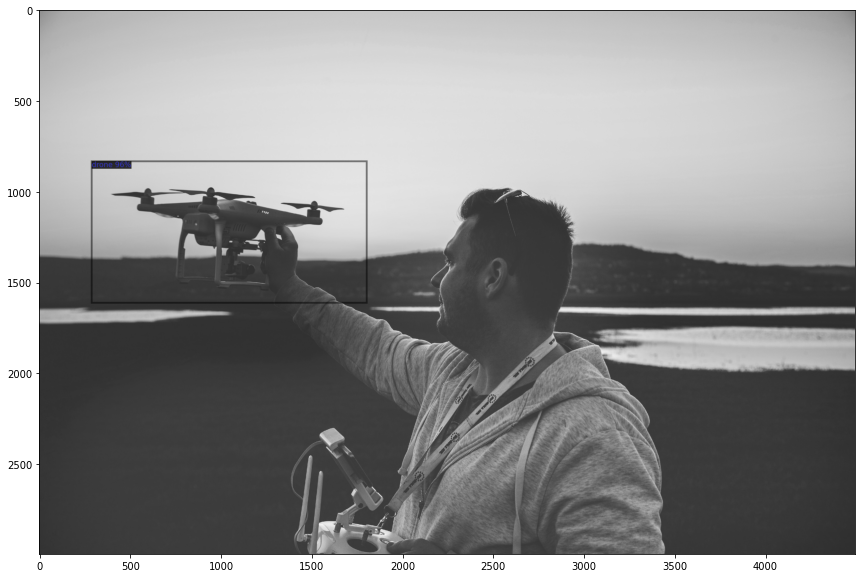

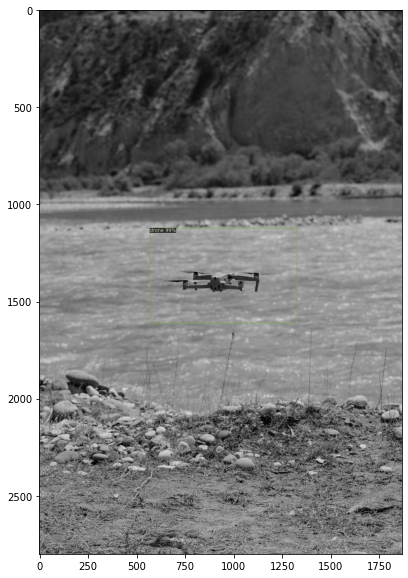

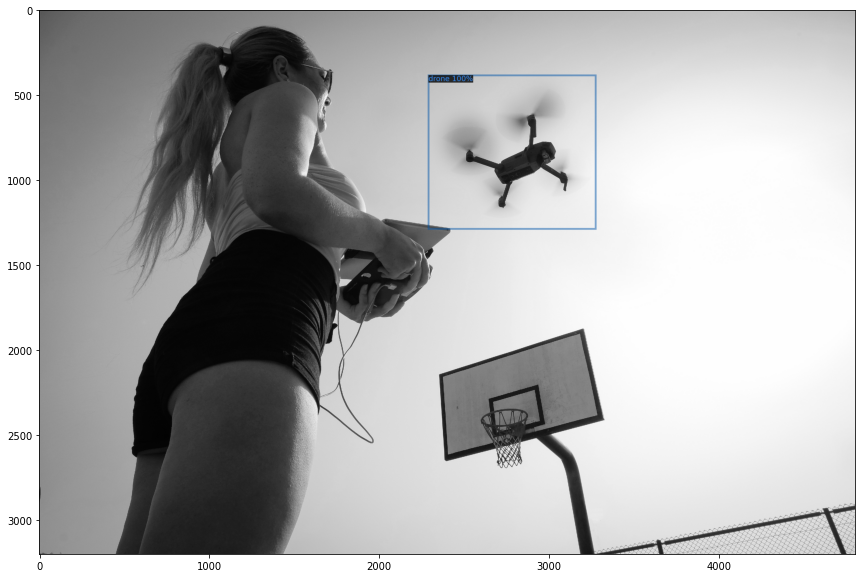

In [17]:
locate_drone_and_show('D:/Dataset/drone_images/drone_images_test/2.jpg')
locate_drone_and_show('D:/Dataset/drone_images/drone_images_test/3.jpg')
locate_drone_and_show('D:/Dataset/drone_images/drone_images_test/4.jpg')
locate_drone_and_show('D:/Dataset/drone_images/drone_images_test/1.jpg')